In [496]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import coo_matrix
import pickle
import random

In [497]:

## Load and preprocess data, remove all users/movies from test data that do not appear in train data
#look but don't touch.
"""
import copy

#ratings_df = pd.read_csv('ml-latest/ratings.csv')
ratings_test_df = pd.read_csv('ml-latest-small/ratings.csv')
print(ratings_test_df.shape)
ratings_df = ratings_test_df.sample(frac=0.33)
ratings_test_df = ratings_test_df.drop(ratings_df.index)
ratings_val_df = ratings_test_df.sample(frac=0.50)
ratings_test_df = ratings_test_df.drop(ratings_val_df.index)
print(ratings_df.shape,ratings_val_df.shape,ratings_test_df.shape)

#hash everything
user_idx = np.unique(ratings_df['userId'])
movie_idx = np.unique(ratings_df['movieId'])

ratings_df_new = copy.deepcopy(ratings_df)
ratings_val_df_new = copy.deepcopy(ratings_val_df)
ratings_test_df_new = copy.deepcopy(ratings_test_df)
for i in range(len(user_idx)):
    ratings_df_new.loc[ratings_df['userId']==user_idx[i], 'userId'] = i
    ratings_val_df_new.loc[ratings_val_df['userId']==user_idx[i], 'userId'] = i
    ratings_test_df_new.loc[ratings_test_df['userId']==user_idx[i], 'userId'] = i
for j in range(len(movie_idx)):
    ratings_df_new.loc[ratings_df['movieId']==movie_idx[j], 'movieId'] = j
    ratings_val_df_new.loc[ratings_val_df['movieId']==movie_idx[j], 'movieId'] = j
    ratings_test_df_new.loc[ratings_test_df['movieId']==movie_idx[j], 'movieId'] = j
    


pickle.dump({'ratings_df':ratings_df_new,'ratings_val_df':ratings_val_df_new,'ratings_test_df':ratings_test_df_new},open('movie_tables.pkl','wb'))
"""

"\nimport copy\n\n#ratings_df = pd.read_csv('ml-latest/ratings.csv')\nratings_test_df = pd.read_csv('ml-latest-small/ratings.csv')\nprint(ratings_test_df.shape)\nratings_df = ratings_test_df.sample(frac=0.33)\nratings_test_df = ratings_test_df.drop(ratings_df.index)\nratings_val_df = ratings_test_df.sample(frac=0.50)\nratings_test_df = ratings_test_df.drop(ratings_val_df.index)\nprint(ratings_df.shape,ratings_val_df.shape,ratings_test_df.shape)\n\n#hash everything\nuser_idx = np.unique(ratings_df['userId'])\nmovie_idx = np.unique(ratings_df['movieId'])\n\nratings_df_new = copy.deepcopy(ratings_df)\nratings_val_df_new = copy.deepcopy(ratings_val_df)\nratings_test_df_new = copy.deepcopy(ratings_test_df)\nfor i in range(len(user_idx)):\n    ratings_df_new.loc[ratings_df['userId']==user_idx[i], 'userId'] = i\n    ratings_val_df_new.loc[ratings_val_df['userId']==user_idx[i], 'userId'] = i\n    ratings_test_df_new.loc[ratings_test_df['userId']==user_idx[i], 'userId'] = i\nfor j in range(len(

In [498]:
# data = pickle.load(open('movie_tables.pkl','rb'))
data = pd.read_pickle('movie_tables.pkl')
ratings_df = data['ratings_df']
ratings_val_df = data['ratings_val_df']
ratings_test_df = data['ratings_test_df']
R = coo_matrix((ratings_df['rating'], (ratings_df['userId'],ratings_df['movieId'])))

print(R.shape, len(np.unique(R.row)), len(np.unique(R.col)))

(610, 6381) 610 6381


In [499]:
#write a function that, given a list of uIDs and mIDs, returns the global average of the train set
global_avg = ratings_df['rating'].mean()

unique_users = set(ratings_df['userId'].unique())
unique_movies = set(ratings_df['movieId'].unique())

user_avg = np.array(ratings_df.groupby('userId').mean('rating')['rating']) - global_avg
movie_avg = np.array(ratings_df.groupby('movieId').mean('rating')['rating']) - global_avg


def predictor(uID,mID):
    return global_avg*np.ones(len(uID)) # global average

def user_avg_predictor(uID, mID):
    user_ratings = [user_avg[x] if x in users else 0 for x in uID]
    return global_avg + np.array(user_ratings)

def movie_avg_predictor(uID, mID):
    movie_ratings = [movie_avg[x] if x in movies else 0 for x in mID]
    return global_avg + np.array(movie_ratings)

def user_movie_avg_predictor(uID, mID):
    ratings = [(0.5 * user_avg[uid] if uid in unique_users else 0) + (0.5 * movie_avg[mid] if mid in unique_movies else 0) for uid, mid in zip(uID, mID)]
    return global_avg + np.array(ratings)

# fill in the RMSE functions, using the predictor as input.
def get_rmse_train(predictor):
    return np.sqrt(((ratings_df['rating'] - predictor(ratings_df['userId'], ratings_df['movieId'])) ** 2).mean())

def get_rmse_val(predictor):
    return np.sqrt(((ratings_val_df['rating'] - predictor(ratings_val_df['userId'], ratings_val_df['movieId'])) ** 2).mean())
    
def get_rmse_test(predictor):
    return np.sqrt(((ratings_test_df['rating'] - predictor(ratings_test_df['userId'], ratings_test_df['movieId'])) ** 2).mean())

## Gradient equations are written in the notes

In [500]:
num_unique_users = len(unique_users)
num_unique_movies = len(unique_movies)

# Get non-zero columns for each user and each movie
non_zero_user_columns = []
for i in range(num_unique_users):
    non_zero_user_columns.append(R.col[R.row == i])

non_zero_movie_rows = []
for j in range(num_unique_movies):
    non_zero_movie_rows.append(R.row[R.col == j])



def get_grad_ui(U,V,i):
    non_zero_indices = np.where((R.row == i) & (R.data != 0))[0]
    non_zero_columns = R.col[non_zero_indices]
    non_zero_values = R.data[non_zero_indices]
    
    grad = 0.0
    for j, rating in zip(non_zero_columns, non_zero_values):
        part1 = U[i] @ V[j]
        part2 = 0.5 * average_user_rating[i] + 0.5 * average_movie_rating[j]
        grad += (part1 + global_avg + part2 - rating) * V[j]
    return grad
    # return np.zeros(r)
    
def get_grad_vj(U,V,j):
    non_zero_indices = np.where((R.col == j) & (R.data != 0))[0]
    non_zero_rows = R.row[non_zero_indices]
    non_zero_values = R.data[non_zero_indices]
    
    grad = 0.0
    for i, rating in zip(non_zero_rows, non_zero_values):
        part1 = U[i] @ V[j]
        part2 = 0.5 * average_user_rating[i] + 0.5 * average_movie_rating[j]
        grad += (part1 + global_avg + part2 - rating) * U[i]
    return grad
    # return np.zeros(r)


In [505]:
print(f'Global Average: {global_avg}')
print('----------------------------------')
print('RMSE using Global Average')
print(f'Train RMSE: {round(get_rmse_train(predictor), 5)}')
print(f'Val RMSE: {round(get_rmse_val(predictor), 5)}')
print(f'Test RMSE: {round(get_rmse_test(predictor), 5)}')

Global Average: 3.499173578555115
----------------------------------
RMSE using Global Average
Train RMSE: 1.04534
Val RMSE: 1.0385
Test RMSE: 1.04378


In [506]:
print('----------------------------------')
print('RMSE using Global And User Average')
print(f'Train RMSE: {round(get_rmse_train(user_avg_predictor), 5)}')
print(f'Val RMSE: {round(get_rmse_val(user_avg_predictor), 5)}')
print(f'Test RMSE: {round(get_rmse_test(user_avg_predictor), 5)}')

----------------------------------
RMSE using Global And User Average
Train RMSE: 0.93035
Val RMSE: 0.94537
Test RMSE: 0.95069


In [507]:
print('----------------------------------')
print('RMSE using Global And Movie Average')
print(f'Train RMSE: {round(get_rmse_train(movie_avg_predictor), 5)}')
print(f'Val RMSE: {round(get_rmse_val(movie_avg_predictor), 5)}')
print(f'Test RMSE: {round(get_rmse_test(movie_avg_predictor), 5)}')

----------------------------------
RMSE using Global And Movie Average
Train RMSE: 0.82984
Val RMSE: 1.01888
Test RMSE: 1.02699


In [508]:
print('----------------------------------')
print('RMSE using Global, User and Movie Average')
print(f'Train RMSE: {round(get_rmse_train(user_movie_avg_predictor), 5)}')
print(f'Val RMSE: {round(get_rmse_val(user_movie_avg_predictor), 5)}')
print(f'Test RMSE: {round(get_rmse_test(user_movie_avg_predictor), 5)}')

----------------------------------
RMSE using Global, User and Movie Average
Train RMSE: 0.81252
Val RMSE: 0.91396
Test RMSE: 0.92019


### Gradient Part

In [509]:
r = 5
U = np.random.normal(0, 1.0/5, size=(num_unique_users, r))
V = np.random.normal(0, 1.0/5, size=(num_unique_movies, r))

In [510]:
def calculate_rmse(data):
    # Calculate predicted ratings matrix
    predicted_ratings = U @ V.T
    rmse = 0.0
    actual_ratings = R.tocsr()

    for user_id, movie_id in zip(data['userId'], data['movieId']):
        # Check if the user ID or movie ID exceeds the shape of the predicted ratings matrix
        if user_id >= predicted_ratings.shape[0] or movie_id >= predicted_ratings.shape[1]:
            pred_rating = global_avg
        else:
            pred_rating = (
                predicted_ratings[user_id][movie_id] +
                global_avg +
                average_user_rating[user_id] * 0.5 +
                average_movie_rating[movie_id] * 0.5
            )

        # Check if the user ID or movie ID exceeds the shape of the actual ratings matrix
        if user_id >= actual_ratings.shape[0] or movie_id >= actual_ratings.shape[1]:
            actual_rating = 0
        else:
            actual_rating = actual_ratings[user_id, movie_id]

        rmse += (pred_rating - actual_rating) ** 2
    rmse /= data.shape[0]
    return np.sqrt(rmse)

In [511]:
step_size = 0.01
train_mse = []
test_mse = []
val_mse = []
iter = 20

for i in list(range(iter)):
    train_mse.append(calculate_rmse(ratings_df))
    test_mse.append(calculate_rmse(ratings_test_df))
    val_mse.append(calculate_rmse(ratings_val_df))
    
    U_mod = np.zeros(U.shape)
    V_mod = np.zeros(V.shape)
    
    for i in range(num_unique_users):
        U_mod[i] = U[i] - step_size * get_grad_ui(U, V, i)
    
    for j in range(num_unique_movies):
        V_mod[j] = V[j] - step_size * get_grad_vj(U, V, j)
    
    U = U_mod
    V = V_mod

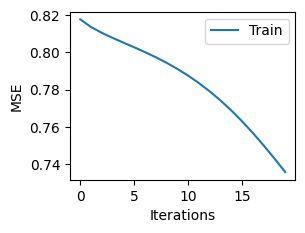

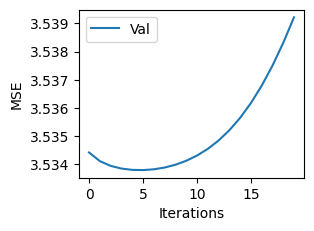

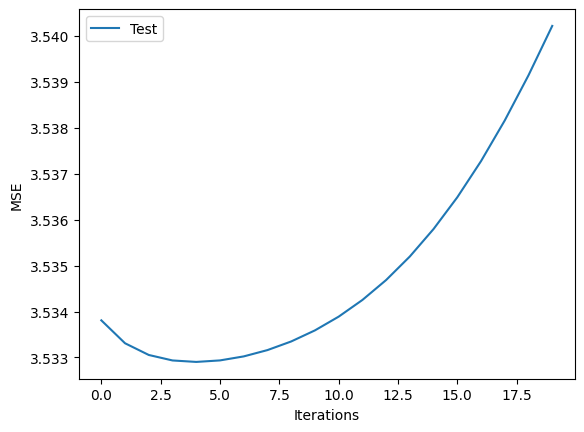

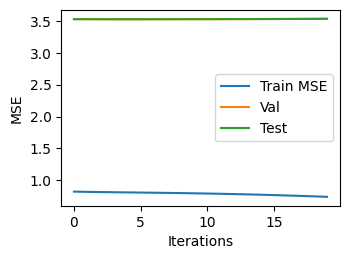

In [512]:
plt.figure()

plt.subplot(2, 2, 1)
plt.plot(list(range(iter)), train_mse, label='Train')
plt.ylabel('MSE')
plt.xlabel('Iterations') 
plt.legend()
plt.show()

plt.subplot(2, 2, 2)
plt.plot(list(range(iter)), val_mse, label='Val') 
plt.ylabel('MSE')
plt.xlabel('Iterations') 
plt.legend()
plt.show()

plt.plot(list(range(iter)), test_mse, label='Test')
plt.ylabel('MSE')
plt.xlabel('Iterations') 
plt.legend()
plt.show()

plt.subplot(2, 2, 4)
plt.plot(list(range(iter)), train_mse, label='Train MSE')
plt.plot(list(range(iter)), val_mse, label='Val') 
plt.plot(list(range(iter)), test_mse, label='Test')
plt.ylabel('MSE')
plt.xlabel('Iterations') 
plt.legend()
plt.tight_layout()
plt.show()

### Now, use the validation set to pick the best value of r and maxiter. Train the model under these hyperparameters, and report the final RMSE of the train, validation, and test set.

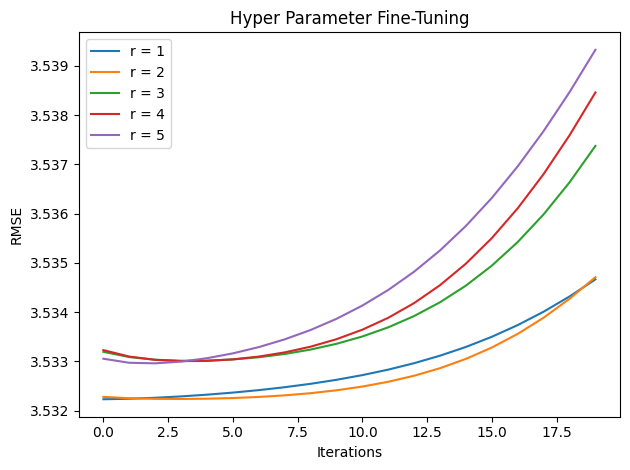

Best Values of r and iterations
r = 1
Iterations = 5
-----------------------------------------------------
Train RMSE: 0.811277890016062
Val RMSE: 3.53227516230972
Test RMSE: 3.5318630488236953


In [518]:
train_mse_2 = []
test_mse_2 = []
val_mse_2 = []

it1 = 20
it2 = 5

for r in [1, 2, 3, 4, 5]:
    train_mse = []
    test_mse = []
    val_mse = []
    U = np.random.normal(0, 1.0/5 ,size=(num_unique_users,r))
    V = np.random.normal(0, 1.0/5, size=(num_unique_movies,r))
    for it in range(it1):
        train_mse.append(calculate_rmse(ratings_df))
        test_mse.append(calculate_rmse(ratings_test_df))
        val_mse.append(calculate_rmse(ratings_val_df))
        U_mod = np.zeros(U.shape)
        V_mod = np.zeros(V.shape)
        for i in range(num_unique_users):
            U_mod[i] = U[i] - step_size * get_grad_ui(U, V, i)
        for j in range(num_unique_movies):
            V_mod[j] = V[j] - step_size*get_grad_vj(U,V,j)
        U = U_mod
        V = V_mod
    train_mse_2.append(train_mse)
    test_mse_2.append(test_mse)
    val_mse_2.append(val_mse)

nv = len(val_mse_2)
fig,ax = plt.subplots(1)
for i in range(nv):
    ax.plot(list(range(it1)), val_mse_2[i], label=f'r = {i + 1}')
ax.set_xlabel('Iterations')
ax.set_ylabel('RMSE')
ax.set_title('Hyper Parameter Fine-Tuning')
ax.legend()
plt.tight_layout()


iterations = val_mse_2[0].index(min(val_mse_2[0])) + 1

## Calculating the best possible values for RMSE. 

train_mse_3 = []
val_mse_3 = []
test_mse_3 = []
U = np.random.normal(0, 1.0/5, size=(num_unique_users,1))
V = np.random.normal(0, 1.0/5, size=(num_unique_movies,1))
for it in range(it2):
    train_mse_3.append(calculate_rmse(ratings_df))
    val_mse_3.append(calculate_rmse(ratings_val_df))
    test_mse_3.append(calculate_rmse(ratings_test_df))
    U_mod = np.zeros(U.shape)
    V_mod = np.zeros(V.shape)
    for i in range(num_unique_users):
        U_mod[i] = U[i] - step_size * get_grad_ui(U, V, i)
    for j in range(num_unique_movies):
        V_mod[j] = V[j] - step_size*get_grad_vj(U,V,j)
    U = U_mod
    V = V_mod

plt.show()

print(f'Best Values of r and iterations')
print(f'r = 1')
print(f'Iterations = 5')
print(f'-----------------------------------------------------')
print(f'Train RMSE: {min(train_mse_3)}')
print(f'Val RMSE: {min(val_mse_3)}')
print(f'Test RMSE: {min(test_mse_3)}')